In [7]:
%load_ext autoreload
%autoreload 2
import sys
import copy
import torch
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import test_metrics
from abstract_gradient_training import privacy_utils
sys.path.append("../")
from models.fully_connected import FullyConnected
from datasets.blobs import get_dataloaders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
"""Set up environment, config, model and datasets"""

# Set plotting and functional parameters
sns.set_theme(context="paper", style="whitegrid", font_scale=1.6)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
SEED = 1234
HIDDEN_DIM = 128
HIDDEN_LAY = 1
BATCHSIZE = 2000
torch.manual_seed(SEED)
RESULTS_DIR = ".results"
NOTEBOOK_ID = "blobs_smooth_sens"
CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
CM_NOMINAL = mpl.colors.ListedColormap(["#FF0000"])
CM_PRIVACY = sns.blend_palette(
    ["#ffffff", "#B5FFE1", "#93E5AB", "#65B891", "#4E878C", "#00241B"], n_colors=200, as_cmap=True
)
CM_PRIVACY = sns.blend_palette(
    ["#ffffff", "#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"], n_colors=200, as_cmap=True
)

# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=2,
    device="cuda:0",
    forward_bound="interval,crown",
    backward_bound="interval",
    loss="cross_entropy",
    lr_decay=0.6,
    clip_gamma=0.08,
    lr_min=1e-3,
    early_stopping=False,
    log_level="WARNING",
)
KS_PRIVACY = list(range(0, 200, 5))

DL_TRAIN_CLOSE, DL_TEST_CLOSE = get_dataloaders(BATCHSIZE, 1, 0.75, SEED)
DL_TRAIN_FAR, DL_TEST_FAR = get_dataloaders(BATCHSIZE, 1.25, 0.35, SEED)

# Initialise the neural network model
MODEL = FullyConnected(in_dim=6, out_dim=2, hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY)

In [6]:
"""Run all sweeps."""

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{RESULTS_DIR}/{NOTEBOOK_ID}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
        param_l = [p.to(config.device) for p in param_l]
        param_n = [p.to(config.device) for p in param_n]
        param_u = [p.to(config.device) for p in param_u]
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(SEED)
        if config.metadata == "close":
            dl_train, dl_test = DL_TRAIN_CLOSE, DL_TEST_CLOSE
        elif config.metadata == "far":
            dl_train, dl_test = DL_TRAIN_FAR, DL_TEST_FAR
        else:
            raise ValueError("metadata should be either close or far")
        
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                MODEL, config, dl_train, dl_test
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                MODEL, config, dl_train, dl_test
            )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

# Run sweeps for close and far blobs datasets, for privacy and unlearning
privacy_results_far = {}

for k in KS_PRIVACY:
    config = copy.deepcopy(NOMINAL_CONFIG)
    config.clip_gamma = 0.08
    config.k_private = k
    config.metadata = "far"
    privacy_results_far[k] = run_with_config(config)

/tmp/ipykernel_3108285/1962088701.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_l, param_n, param_u = torch.load(fname)


In [14]:
"""Compute utilities when using smooth sensitivity for a reduced noise level."""

epsilons = torch.logspace(-2, 1, 40)
test_point, test_label = next(iter(DL_TEST_FAR))
param_n = next(iter(privacy_results_far.values()))[1]
cauchy_means = []
cauchy_stds = []
laplace_means = []
laplace_stds = []
noise_free_acc = test_metrics.test_accuracy(param_n, param_n, param_n, test_point, test_label)[1]

n_runs = 100

for epsilon in epsilons:
    noise_level = privacy_utils.get_calibrated_noise_level(
        test_point, test_label, privacy_results_far, float(epsilon), noise_type="cauchy"
    )
    
    private_accs_cauchy = []
    private_accs_laplace = []
    for _ in range(n_runs):
        private_accs_cauchy.append(
            privacy_utils.noisy_test_accuracy(
                param_n, test_point, test_label, noise_level=noise_level, noise_type="cauchy"
            )
        )
        private_accs_laplace.append(
            privacy_utils.noisy_test_accuracy(
                param_n, test_point, test_label, noise_level=1 / epsilon, noise_type="laplace"
            )
        )
    cauchy_means.append(np.mean(private_accs_cauchy))
    cauchy_stds.append(np.std(private_accs_cauchy))
    laplace_means.append(np.mean(private_accs_laplace))
    laplace_stds.append(np.std(private_accs_laplace))

print(laplace_means)
print(cauchy_means)

[np.float64(0.5000400218367577), np.float64(0.5044600212574005), np.float64(0.5055400216579438), np.float64(0.503640022277832), np.float64(0.5067200231552124), np.float64(0.5054000243544579), np.float64(0.5082600203156471), np.float64(0.5109800246357917), np.float64(0.5045600247383117), np.float64(0.5131400239467621), np.float64(0.5138200253248215), np.float64(0.5183000263571739), np.float64(0.5164200240373611), np.float64(0.5254800245165825), np.float64(0.5313600257039071), np.float64(0.5344400298595429), np.float64(0.5391200232505798), np.float64(0.5464400237798691), np.float64(0.5524200284481049), np.float64(0.5658800280094147), np.float64(0.5771400284767151), np.float64(0.5970400267839432), np.float64(0.6058400315046311), np.float64(0.6333800292015076), np.float64(0.6474800336360932), np.float64(0.6715600323677063), np.float64(0.6962200325727462), np.float64(0.7277000349760055), np.float64(0.7537800347805024), np.float64(0.7859800374507904), np.float64(0.8196600395441055), np.float

In [15]:
"""Add constant noise, and compute the local epsilons."""

delta = 10 ** -5

local_eps = []

for epsilon in epsilons:
    local_epsilons = privacy_utils.compute_local_epsilons(
        test_point, test_label, privacy_results_far, float(epsilon), delta
    )
    local_eps.append(local_epsilons.mean().item())

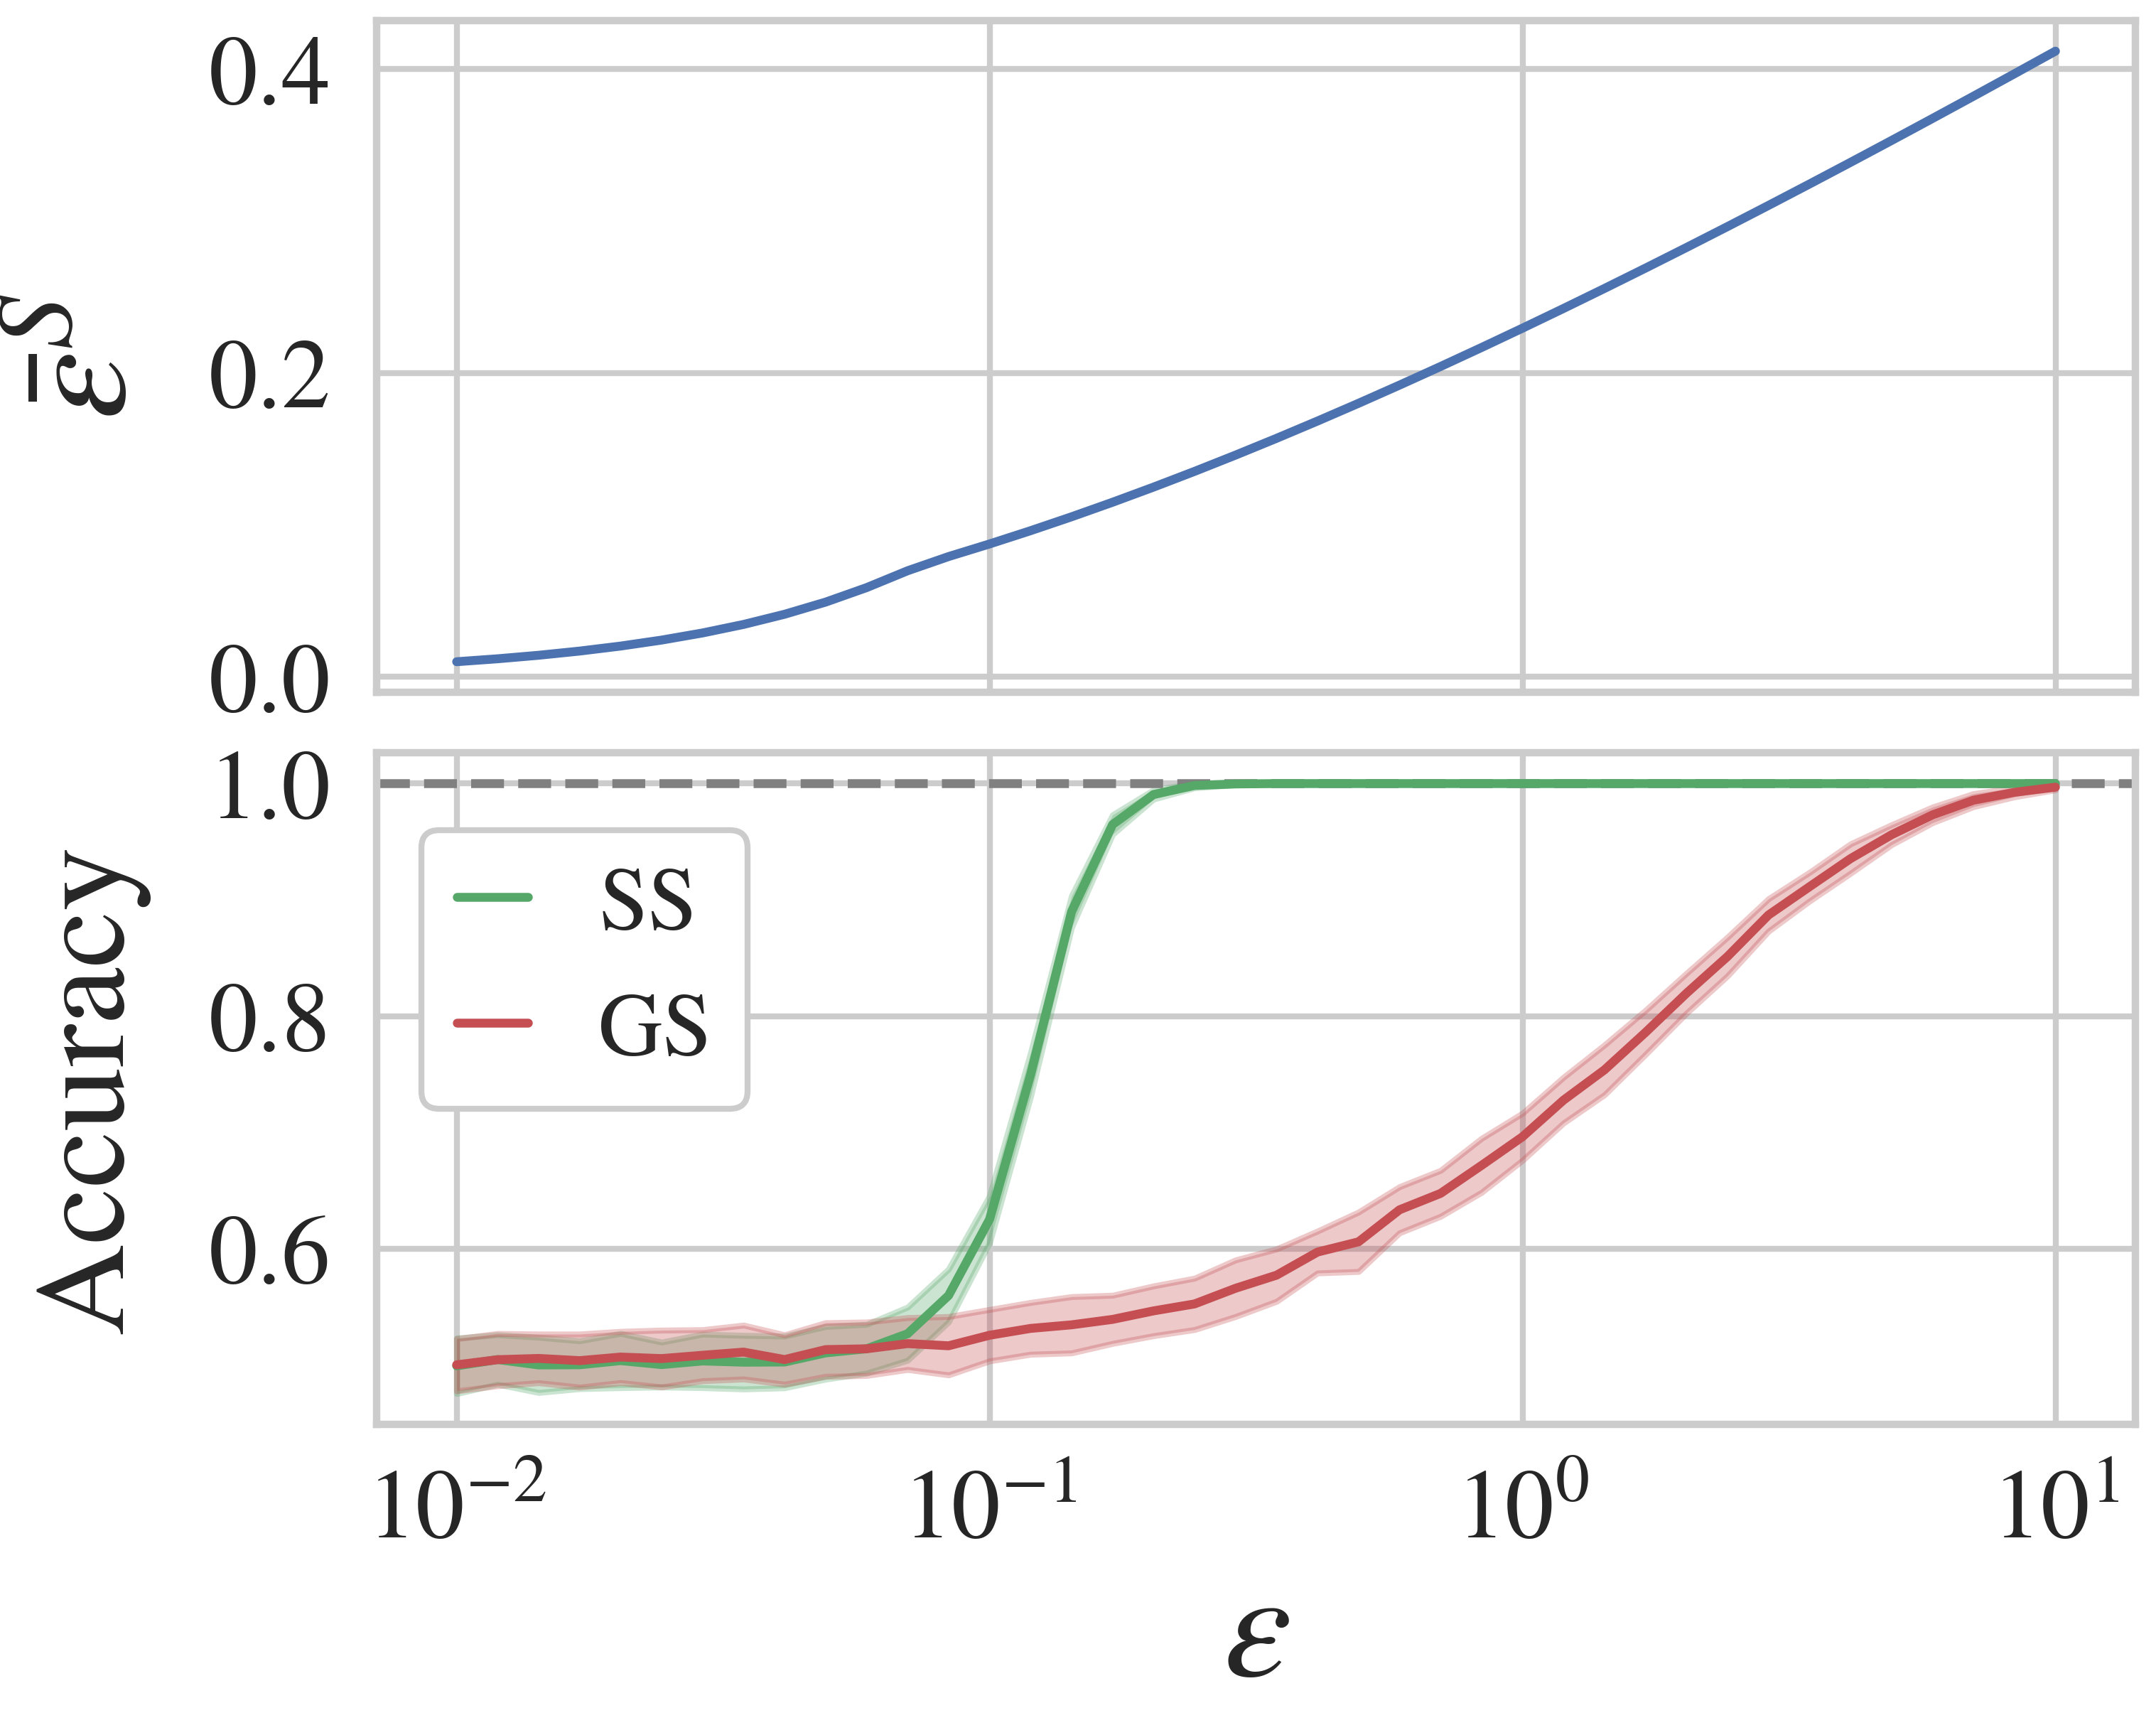

In [16]:
"""Plot the results."""
barcolor = sns.color_palette("deep")[0]
laplacecolor = sns.color_palette("deep")[3]
cauchycolor = sns.color_palette("deep")[2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained", sharex=True, dpi=300)

axs[0].set_xscale("log")
axs[1].set_xlabel("$\epsilon$", fontsize="x-large")

axs[0].plot(epsilons, np.array(local_eps), c=barcolor)

axs[1].set_ylabel("Accuracy", fontsize="large", labelpad=20)
axs[0].set_ylabel(r"${\bar{\epsilon}^S}$", fontsize="x-large", labelpad=40, va="center")

axs[1].axhline(noise_free_acc, c="gray", linestyle="--")
axs[1].plot(epsilons, cauchy_means, c=cauchycolor, label="SS")
axs[1].fill_between(
    epsilons,
    np.array(cauchy_means) - np.array(cauchy_stds),
    np.array(cauchy_means) + np.array(cauchy_stds),
    color=cauchycolor,
    alpha=0.3,
)
axs[1].plot(epsilons, laplace_means, c=laplacecolor, label="GS")
axs[1].fill_between(
    epsilons,
    np.array(laplace_means) - np.array(laplace_stds),
    np.array(laplace_means) + np.array(laplace_stds),
    color=laplacecolor,
    alpha=0.3,
)
axs[1].legend(loc="upper left", handlelength=0.8, framealpha=1.0, bbox_to_anchor=(0.0, 0.95), fontsize="small")
axs[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
axs[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
plt.savefig(".figures/blobs_ss_usage_far.pdf", bbox_inches="tight", dpi=300)